# **Notebook: Introdução à Computação no Mercado Financeiro**

**Trabalho 2: Modelos de fatores para seleção de portifólios de ações**

SSC0964 - Prof. Denis Fernando Wolf

Instituto de Ciências Matemáticas e de Computação (ICMC-USP)

Amanda Araujo Silva

*Link Colab*: https://colab.research.google.com/drive/1gPS3GaD1g5d_g0BDTrjcAl9oSO3fN13A?usp=sharing

# Descrição do trabalho

A partir do material visto nas aulas, criar 2 modelos de fatores para a seleção de portfólios de ações (maior rentabilidade e menor volatilidade), sendo que cada modelo deve ter pelo menos 2 fatores combinados.

 A avaliação levará em conta a forma como as ações são escolhidas, como os modelos são otimizados, os resultados obtidos e o número de alunos no grupo.

# Instalação de pacotes e bibliotecas

In [ ]:
# Bibliotecas e pacotes úteis
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Otimização de portifólios:
!pip install Riskfolio-Lib

In [ ]:
import riskfolio as rp

# Leitura dos dados

Fonte dos dados: Dados Economática.
> *Sistema de análise de investimentos sobre mercados de capitais das principais economias da América Latina e EUA. Balanços, cotações, proventos, composição acionária de empresas, IBOVESPA, IGP-M, FGV100, Dow Jones e outros. Séries históricas desde 1986.*

In [ ]:
#Def de variáveis importantes e leitura dos arquivos
#período da avaliação do portifólio

data_inicial = 13 #  13 = 01/2005
data_final   = data_inicial + 192 # 12/2020
colunas = 291 #len(comp_indice.columns)
step_port = 1
step_eval = 1

#Composição do índice IBX
comp_indice=pd.read_excel('Dados-Comp-IBRX.xlsx', engine='openpyxl')
comp_indice.set_index(keys = 'Data', inplace = True)

#Preços de fechamento dos ativos
fechamento=pd.read_excel('Dados-Fechamento.xlsx', engine='openpyxl')
fechamento.set_index(keys = 'Data', inplace = True)

#Indices de referência (Ibov, IBX, SELIC...)
referencias=pd.read_excel('Dados-Base.xlsx', engine='openpyxl')
referencias.set_index(keys = 'Data', inplace = True)
#-------------------------------------------
# Leitura dos ativos e ranking de acordo com o fator
# Análise se o fator é consistente
# Empresas que tendem a se beneficiar desse fator aparecem mais em cima do ranking

# Fator Qualidade (ROIC das empresas)
fator_ROIC=pd.read_excel('Dados-ROIC-A2.xlsx', engine='openpyxl')
fator_ROIC.set_index(keys = 'Data', inplace = True)
ranked_ROIC=fator_ROIC.rank(axis=1, numeric_only=True, ascending=False, method='first')

# Fator Momentum (Momentum de 12 meses)
fator_Mom=pd.read_excel('Dados-Momentum-12.xlsx', engine='openpyxl')
fator_Mom.set_index(keys = 'Data', inplace = True)
ranked_Mom=fator_Mom.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Tamanho (Valor de mercado das empresas)
fator_Val_Merc=pd.read_excel('Dados-Val-Merc.xlsx', engine='openpyxl')
fator_Val_Merc.set_index(keys = 'Data', inplace = True)
ranked_Val_Merc=fator_Val_Merc.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Valor (Preço / Valor Patrimonial)
fator_PVP=pd.read_excel('Dados-PVP.xlsx', engine='openpyxl')
fator_PVP.set_index(keys = 'Data', inplace = True)
ranked_PVP=fator_PVP.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Volatilidade (Volatilidade em 12 meses)
fator_Vol=pd.read_excel('Dados-Vol-12.xlsx', engine='openpyxl')
fator_Vol.set_index(keys = 'Data', inplace = True)
ranked_Vol=fator_Vol.rank(axis=1, numeric_only=True, ascending=True, method='first')

print("Periodo de avaliacao - de:", comp_indice.index[data_inicial], "(", data_inicial, ")",  "ate:", comp_indice.index[data_final-1], "(", data_final-1, ")")
print("Rebalanceamento a cada", step_eval,"/", step_port, "meses")

Periodo de avaliacao - de: Jan-2005 ( 13 ) ate: Dez-2020 ( 204 )
Rebalanceamento a cada 1 / 1 meses


Dos dados da base paga Economática temos inúmeros indicadores e informações sobre ações, dentre eles registros dos seguintes **fatores**:
* Qualidade (ROIC - Retorno Sobre Capital Investido)
* Momentum (em 12 meses)
* Tamanho (Valor de mercado da empresa)
* Valor (Preço/Valor Patrimonial)
* Volatilidade (em 12 meses)

Obtivemos o ranking simples respectivamente a cada um dos fatores analisados no período.

# Funções de apoio

In [ ]:
#Funções de apoio

#Seleção das ações que compõe um portfólio.
#Parâmetros: (fator, ranking_inicio, ranking_fim)
#Retorno: portfólio

def SelPort1(port_ranked_1, param_1a, param_1b):

    port_ranked_final = port_ranked_1.copy()
    port_ranked_final.loc[:, :] = 0

    for lin in range(data_inicial, data_final, step_port):
        for col in range(0, colunas):
            if ((port_ranked_1.iat[lin-1, col]  >= param_1a) and (port_ranked_1.iat[lin-1, col]  <= param_1b)):
                port_ranked_final.iat[lin-1, col] = 1

    return port_ranked_final
#--------------------------

#Avaliação de um portfólio.
#Parâmetros: (portfólio, histórico de preços dos ativos)
#Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada

def EvalPort(port, fechamento):
    port_acc_vet = []
    port_chg_vet = []
    port_ddown_vet = []

    port_acc = 1.0
    port_acc_vet.append(1.0)
    cost_trans = 0.0006
    #cost_trans = 0.0005 + (0.004*step_eval/12)

    for lin in range(data_inicial, data_final, step_eval):
        cont = 0.0
        rent = 0.0
        for col in range(0, colunas):
            if (port.iat[lin-1, col] > 0 and fechamento.iat[lin-1, col]>0 and fechamento.iat[lin-1+step_eval, col]>0):
                rent = rent + (fechamento.iat[lin-1+step_eval,col]/fechamento.iat[lin-1,col]-1)*(port.iat[lin-1, col])
                cont = cont + port.iat[lin-1, col]
        if (cont == 0):
          return [1,1], [1,1], [0,0], 0, 0.000001
        port_acc = port_acc * (1.0 + rent/cont - cost_trans)
        port_chg_vet.append(rent/cont - cost_trans)
        port_acc_vet.append(port_acc)
        port_ddown_vet.append(port_acc/(np.max(port_acc_vet))-1)

    ret_aa = pow(port_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(port_chg_vet)*((12/step_eval)**(1/2))
    return port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa
#retorno acumulado, volatilidade acumulada, drawdown máximo, retorno anualizado, volatilidade anualizada
#--------------------------

#Avaliação de um índice de referência.
#Parâmetros: (dataframe de referências, indice da referência desejada [0 - Ibovespa, 1 - IBX])
##Retorno: vetor com retorno acumulado, vetor com retornos periódicos, vetor com drawdown, retorno anualizado, volatilidade anualizada
#versão simplificada da função anterior

def EvalRef(ref, ind):
    ref_acc_vet = []
    ref_chg_vet = []
    ref_ddown_vet = []

    ref_acc = 1.0
    ref_acc_vet.append(1.0)

    for lin in range(data_inicial, data_final, step_eval):
        rent = ref.iat[lin-1+step_eval,ind]/ref.iat[lin-1,ind]
        ref_acc = ref_acc * rent
        ref_chg_vet.append(rent-1)
        ref_acc_vet.append(ref_acc)
        ref_ddown_vet.append(ref_acc/(np.max(ref_acc_vet))-1)

    ret_aa = pow(ref_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(ref_chg_vet)*((12/step_eval)**(1/2))
    return ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa, vol_aa
#--------------------------

#Seleção das ações que compõe um portfólio com 2 fatores.
#Parâmetros: (fator1, limite1, fator2, limite2)
#Retorno: portfólio

def SelPort2Par(ranked_1, param_1, ranked_2, param_2):
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final

In [ ]:
# Função de otimização que prepara os dados e utiliza o Riskfolio para fazer otimização
#   port, qual a otimização: {RP: risk parity, GMV: global min variance,
#                             MDP: max decorrelation port}

#-------------------------- Riskfolio ----------

def calc_riskfolio_opt (ranked, otim_opt):
  hist_size = 24
  port = ranked.copy()
  #rm = rm_par

  if (otim_opt == 'RP'):
    print("\nCalc. Risk Parity Portfolio")
  elif (otim_opt == 'GMV'):
    print("\nCalc. Global Minimun Variance Portfolio")
  elif (otim_opt == 'MDP'):
    print("\nCalc. Maximun Decorrelation Portfolio")
  else:
    print("\nOpcao Invalida.")

#  print("\nCalc HRP")

  for lin in range(data_inicial+hist_size, data_final, 1):
    print("\r",lin, "/", data_final-1, end=' ')
    port_comp = pd.DataFrame()
    for col in range(0, colunas):
      if (port.iat[lin-1, col] > 0):
        port_comp[port.columns[col]]=fechamento[port.columns[col]].iloc[lin-1-hist_size:lin-1]

    port_comp.fillna(method='backfill', axis=0, inplace=True)

    port_comp_chg = port_comp.pct_change().dropna()

#---------
    # Hierarchical Risk Parity
    #hrp_port = rp.HCPortfolio(returns=port_comp_chg)
    #w = hrp_port.optimization(model=model, codependence=codependence, rm='MV', rf=0, linkage='average', max_k=10, leaf_order=True)

    # Standard Risk Parity
    if (otim_opt == 'RP'):
      rp_port = rp.Portfolio(returns=port_comp_chg)
      rp_port.assets_stats(d=0.94, method_cov='hist')
      w = rp_port.rp_optimization(rm='MV', b = None)

    # Minimun Variance
    elif (otim_opt == 'GMV'):
      gmv_port = rp.Portfolio(returns=port_comp_chg)
      gmv_port.assets_stats(d=0.94)
      w = gmv_port.optimization(model='Classic', rm='MV', obj='MinRisk')

    # Maximun Decorrelation
    elif (otim_opt == 'MDP'):
      mdp_port = rp.Portfolio(returns=port_comp_chg)
      mdp_port.assets_stats(d=0.94)
      mdp_port.cov = port_comp_chg.corr()
      w = mdp_port.optimization(model='Classic', rm='MV', obj='MinRisk')

#-----------

    port_len = len(port_comp_chg.columns)
    for at in range(port_len):
      port.at[port.index[lin-1], port_comp.columns[at]] = w['weights'].iat[at]
      #if ((lin-1)==40):
      #  print(port_comp.columns[at], w['weights'].iat[at])

    #if ((lin-1)==40):
    #  display(w)

  port_final = port.copy()
  return port_final

# Modelos (multi)fatores

## Passos preliminares

**Tarefa**: Criação de um portifólio de ações empregando múltiplos fatores, de modo a selecionar ao final do processo um portifólio de maior rentabilidade e menor volatilidade.

O primeiro passo consiste em investigar como se comportaram os índices de referência no período analisado (Jan-2005 até Dez-2020, 16 anos ou 192 meses).

In [ ]:
#1ª análise: índices de referência
#{0: ibovespa, 1: ibx, 2: selic, 3: ipca}

# Cálculo de rentabilidade / volatilidade / drawdown da SELIC
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
print("Ref SELIC:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do Ibovespa
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
print("Ref Ibov:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do IBX
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
print("Ref IBX:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

Ref SELIC:
Ret. Acc.: 397.54 % Ret. Anual.: 10.55 % Vol.: 1.05 % Ret/Vol: 10.04 DDown: 0.0 %
Ref Ibov:
Ret. Acc.: 354.33 % Ret. Anual.: 9.92 % Vol.: 23.45 % Ret/Vol: 0.42 DDown: -49.59 %
Ref IBX:
Ret. Acc.: 546.22 % Ret. Anual.: 12.37 % Vol.: 22.69 % Ret/Vol: 0.55 DDown: -49.74 %


SELIC: *A SELIC é a taxa básica de juros da economia. É o principal instrumento de política monetária utilizado pelo Banco Central (BC) para controlar a inflação. Ela influencia todas as taxas de juros do país, como as taxas de juros dos empréstimos, dos financiamentos e das aplicações financeiras.* Fonte: https://www.bcb.gov.br/controleinflacao/taxaselic

Ibov (IBOVESPA): *O Ibovespa significa Índice da Bolsa de Valores de São Paulo. Ele é o principal indicador de desempenho médio das ações listadas. Basicamente, esse índice é uma carteira teórica de ações que contém os ativos que movimentam os maiores volumes de negociação, algo em torno de 80% do total diário. A carteira do Ibovespa é reavaliada a cada quatro meses. Assim, a composição tende a variar ao longo do tempo. Por conta da sua representatividade, o Ibovespa é considerado o benchmark da renda variável. Então, se você quer saber como está o seu desempenho, basta compará-lo ao IBOV.
Caso ele esteja maior ou igual, em termos de valorização, é sinal de que os seus investimentos estão indo bem.* Fonte: https://riconnect.rico.com.vc/blog/ibovespa/

IBX: *O Índice Brasil, também conhecido como IBX, é um índice que mede o retorno de uma carteira hipotética composta por 100 ações selecionadas entre as mais negociadas na BOVESPA, em termos de número de negócios e volume financeiro, ponderadas no índice pelo seu respectivo valor de mercado.*
Fonte: https://www.bussoladoinvestidor.com.br/abc_do_investidor/ibx/

> Esses índices (SELIC, IBOVESPA, IBX) nos servem de base para ilustrar a dinâmica econômica do período, e nos dão alvos do que o nosso portifólio precisa bater para ser capaz de superar o mercado. Isto é, a ideia é criar um portifólio que exceda o desempenho do mercado, idealmente com maior retorno acumulado (ou anual) e menor volatilidade do que a referência Ibov e IBX. No período em questão, a meta seria conseguir um retorno acumulado de pelo menos 546,22%, uma volatilidade abaixo de 22,69% e drawdown inferior a |-49%|.  

Na criação do nosso portifólio, ao invés de focar na escolha das ações individualmente e em uma análise fundamentalista dessas, utilizaremos a estratégia de *factor investing*, na qual nos baseamos no desempenho das ações em relação a fatores de interesse que estejam ligados ao seu dinamismo.

Vamos explorar rapidamente os dados que temos para o ranking de cada um desses fatores...

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)

# Valor (P/VP)
ranked1 = SelPort1(ranked_PVP, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

# Qualidade (ROIC)
ranked2 = SelPort1(ranked_ROIC, 0, 30)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

## Modelo multifatores 1

### Construção do portifólio

Modelo de portifólio de 2 fatores:
* Valor (Preço / Valor Patrimonial)
* Qualidade (ROIC)

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)

# Valor (P/VP)
ranked1 = SelPort1(ranked_PVP, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

# Qualidade (ROIC)
ranked2 = SelPort1(ranked_ROIC, 0, 30)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

Port 1:
Ret. Acc.: 564.57 % Ret. Anual.: 12.57 % Vol.: 29.63 % Ret/Vol: 0.42 DDown: -76.25 %
Port 2:
Ret. Acc.: 638.68 % Ret. Anual.: 13.31 % Vol.: 20.75 % Ret/Vol: 0.64 DDown: -48.83 %


> Já num primeiro momento, olhando para protifólios de um único fator (Valor e ROIC), considerando as 30 primeiras ações de um ranking simples, vemos que ambos apresentam melhor retorno do que IBX, no entanto a volatilidade e o drawdown do fator Valor deixam a desejar...

Testando para as 40 primeiras ações, observa-se uma leve melhora em relação ao drawdown, volatilidades praticamente se mantém, enquanto o retorno aumenta consideravelmente:

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)

# Valor (P/VP)
ranked1 = SelPort1(ranked_PVP, 0, 40)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

# Qualidade (ROIC)
ranked2 = SelPort1(ranked_ROIC, 0, 40)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

Port 1:
Ret. Acc.: 693.93 % Ret. Anual.: 13.82 % Vol.: 27.74 % Ret/Vol: 0.5 DDown: -68.18 %
Port 2:
Ret. Acc.: 810.91 % Ret. Anual.: 14.81 % Vol.: 20.4 % Ret/Vol: 0.73 DDown: -48.58 %


**Quantas ações devo ter na carteira?**
*Para responder essa pergunta, não há um consenso entre Analistas e Assessores de investimento de um número exato para todas as pessoas. Contudo, com o intuito de alcançar uma diversificação, a ideia é ter ao menos 10 ações de 10 setores diferentes. Já o número máximo vai depender da característica de cada investidor, seus objetivos e prazo de investimento.* Fonte: https://blog.toroinvestimentos.com.br/bolsa/quantas-acoes-ter-na-carteira

> Como pretendemos tomar a intersecção entre o ranking de dois fatores, escolheu-se um número razoável de ações para cada um dos fatores (top30), de modo ao final do processo ainda sermos capazes de obter um portifólio diversificado em termos de quantidade de ações distintas.

Para um primeiro portofólio baseado em multifatores, testaremos a combinação dos fatores Valor e Qualidade, com base na intersecção das ações presentes no ranking simples de cada fator.

In [ ]:
#Intersecção: Valor (P/VP) & Qualidade (ROIC); 30 primeiras do ranking de cada fator
ranked3 = SelPort2Par(ranked_PVP, 30, ranked_ROIC, 30)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("\nPort 3:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")


Port 3:
Ret. Acc.: 0 % Ret. Anual.: 0 % Vol.: 0.0 % Ret/Vol: 0.0 DDown: 0 %


> Obtivemos um portifólio vazio, i.e. a intersecção entre as 30 primeiras ações dos rankings de valor e qualidade foi vazia.

Aumentando para o top40:

In [ ]:
#Intersecção: Valor (P/VP) & Qualidade (ROIC); 40 primeiras do ranking de cada fator
ranked3 = SelPort2Par(ranked_PVP, 40, ranked_ROIC, 40)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("\nPort 3:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")


Port 3:
Ret. Acc.: 2762.97 % Ret. Anual.: 23.32 % Vol.: 26.27 % Ret/Vol: 0.89 DDown: -60.37 %


> Na primeira tentativa com 30 ativos, aparentemente os fatores Valor e ROIC não costumam andar muito bem juntos em termos de desempenho no ranking, porém a avaliação do portifólio obtido para a combinação dos dois para o top40 dos rankings de cada um deles parece indicar que há algo interessante nessa combinação, se refletindo em um retorno que impressiona.

> Nota-se um retorno acumulado extraordinário em relação aos índices Ibov e IBX (na ordem dos milhares!), no entanto, em contra-partida a volatilidade e o drawdown do portifólio são um pouco maiores.

Ref Ibov:
Ret. Acc.: 354.33 % Ret. Anual.: 9.92 % Vol.: 23.45 % Ret/Vol: 0.42 DDown: -49.59 %

Ref IBX:
Ret. Acc.: 546.22 % Ret. Anual.: 12.37 % Vol.: 22.69 % Ret/Vol: 0.55 DDown: -49.74 %


> Além disso, é interessante notar como a combinação dos dois fatores é capaz de superar em muito o retorno para os portifólios de um único fator; enquanto

Port 1: (Valor (P/VP))
Ret. Acc.: 693.93 % Ret. Anual.: 13.82 % Vol.: 27.74 % Ret/Vol: 0.5 DDown: -68.18 %

Port 2: (Qualidade (ROIC))
Ret. Acc.: 810.91 % Ret. Anual.: 14.81 % Vol.: 20.4 % Ret/Vol: 0.73 DDown: -48.58 %

Port 3: (Valor & Qualidade)
Ret. Acc.: 2762.97 % Ret. Anual.: 23.32 % Vol.: 26.27 % Ret/Vol: 0.89 DDown: -60.37 %





### Quantas ações temos no portifólio combinado? E quais são essas ações?

In [ ]:
#ranked3 #ações nas colunas
for lin in range(data_inicial, data_final, step_port):
  for col in range(0, colunas):
    if (ranked3.iat[lin-1, col] != 0):
      print(col)

> Nota-se que nosso portifólio é atualizado conforme os dados são atualizados (mensalmente), i.e. a cada mês temos uma lista de ações que compõem o port3, sujeita a mudanças conforme os fatores de Valor e ROIC das empresas muda. No período analisado temos 16 anos = 192 meses, logo temos a dinâmica do portifólio sendo atualizada mensalmente.

In [ ]:
#ranked3 #ações nas colunas
comp_port3 = []
comp_data_len = []

for lin in range(data_inicial, data_final, step_port):
  comp_data = []
  for col in range(0, colunas):
    if (ranked3.iat[lin-1, col] != 0):
      comp_data.append(col)
  comp_port3.append(comp_data)
  comp_data_len.append(len(comp_data))
print(comp_port3)
print(comp_data_len)
print(len(comp_data_len))
print(len(comp_port3))

In [ ]:
print(max(comp_data_len))
print(min(comp_data_len))
print(np.mean(comp_data_len))

17
4
8.359375


> Investigando um pouco mais, observa-se que além da composição do portifólio mudar (diferentes ações em diferentes momentos), a *quantidade* de ações também se altera. No período em questão, variando de um mínimo de 4 até um máximo de 17 ativos, com uma média de 8 ações compondo o portifólio.

E quais são essas ações?

In [ ]:
acoes = list(ranked3.columns.values) #291 ações distintas
#print(acoes)

ac = []
for i in comp_port3[191]: #192 linhas (período: 16anos*12meses = 192)
  acc = []
  for j in range(3, len(acoes[i])):
    acc.append(acoes[i][j])
  acc = ''.join(acc)
  ac.append(acc)
print(ac)
print(len(ac))

['CSMG3', 'CPLE6', 'CYRE3', 'ENBR3', 'ITSA4', 'JBSS3', 'JHSF3', 'MDIA3', 'SBSP3', 'SAPR11', 'TRPL4']
11


Por exemplo, para o último mês do período analisado (dez-2020), teríamos nosso portifólio composto por 11 ações, sendo elas:

*   CSMG3: Companhia de Saneamento de Minas Gerais (Copasa);
*   CPLE6: Companhia Paranaense de Energia;
*   CYRE3: Cyrela é uma incorporadora e construtora de imóveis residenciais sediada no estado de São Paulo;
*   ENBR3: EDP Energias do Brasil é uma holding brasileira do setor elétrico. A companhia é controlada pela EDP Portugal, uma das principais operadoras europeias no setor energético. Suas ações (ENBR3) participam do Novo Mercado da B3;
* ITSA4: Itaúsa Holdings, maior acionista do Banco Itaú, é uma holding brasileira de investimentos de capital aberto;
* JBSS3: JBS empresa brasileira do setor de alimentos fundada em 1953 em Goiás;
* JHSF3: empresa brasileira que atua nos setores de shopping centers, incorporação imobiliária, hotelaria e gastronomia - setor imobiliário de alta renda;
* MDIA3: M. Dias Branco é uma companhia de alimentos brasileira que fabrica, comercializa e distribui biscoitos, massas, bolos, etc. Piraquê, etc;
*  SBSP3: Companhia de Saneamento Básico do Estado de São Paulo - Sabesp;
* SAPR11: Companhia de Saneamento do Paraná;
* TRPL4:  ISA CTEEP é uma empresa concessionária de transmissão de energia elétrica brasileira.




> É curioso como entre apenas as 11 ações que compunham o portifólio em um determinado momento, 3 sejam de saneamento e 3 do setor de energia; supostamente altamente correlacionadas devido ao mesmo setor de atuação. E mesmo com meses de composição muito similar como essa, o portifólio em um longo período foi capaz de render um retorno enorme. Talvez essas altas correlações as quais a intersecção do top40 dos fatores Valor (P/VP) e Qualidade (ROIC) promove sejam a explicação por trás da volatilidade e do drawdonw do portifólio levemente maiores do que o do IBX.

Outro exemplo, buscando quais foram as ações que permaneceram no momento de menor diversidade do portifólio, com apenas 4 ativos:

In [ ]:
index = comp_data_len.index(4)
print(index)

ac = []
for i in comp_port3[index]: #192 linhas (período: 16anos*12meses = 192)
  acc = []
  for j in range(3, len(acoes[i])):
    acc.append(acoes[i][j])
  acc = ''.join(acc)
  ac.append(acc)
print(ac)
print(len(ac))

78
['CNFB4', 'CSMG3', 'EVEN3', 'VIVT4']
4


Index: 78 ~ por volta de 2010. As ações que compunham o portifólio eram:

*  CNFB4: CONFAB PN N1, siderurgia e metalurgia, artefatos de ferro e aço *data da última cotação: 11/05/2012;
*  CSMG3: Companhia de Saneamento de Minas Gerais (Copasa);
*  EVEN3: Even é uma construtora e incorporadora brasileira;
*  VIVT4: Vivo - Telefônica Brasil.



> Pelo menos para essa situação de um número muito reduzido de ativos, observa-se que as ações correspondem à empresas com áreas de atuação distintas, mais diversificado nesse sentido.

Text(0, 0.5, 'Meses')

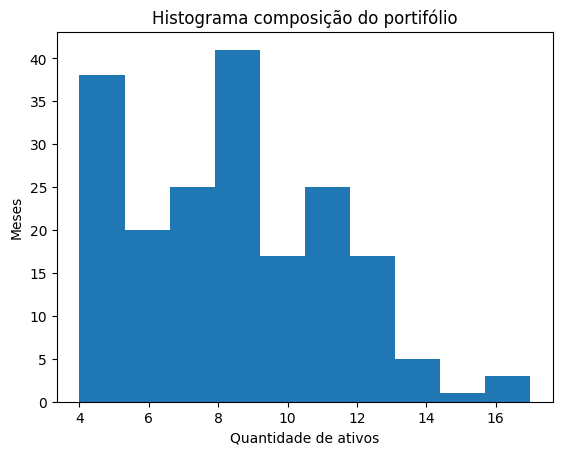

In [ ]:
plt.hist(comp_data_len)
plt.title("Histograma composição do portifólio")
plt.xlabel("Quantidade de ativos")
plt.ylabel("Meses")

### Análise do portifólio

In [ ]:
print("Port 3:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")

Port 3:
Ret. Acc.: 2762.97 % Ret. Anual.: 23.32 % Vol.: 26.27 % Ret/Vol: 0.89 DDown: -60.37 %


In [ ]:
# CAPM: Capital Asset Pricing Model
# Cálculo de Alpha e Beta aproximados. Parâmetros: (indice_de_referencia, portfolio, coluna_do indice de referencia [0 - Ibovespa, 1 - IBX])
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet3, 1)
print("Port3 Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

Port3 Alpha: 11.61 %, Beta: 0.91


> Oscilação desse portifólio corresponde a 90% da oscilação do índice do mercado e apresenta prêmio de 11,61% anualizado. O beta inferior a 1 significa que o portifólio é, teoricamente, menos volátil do que o mercado.

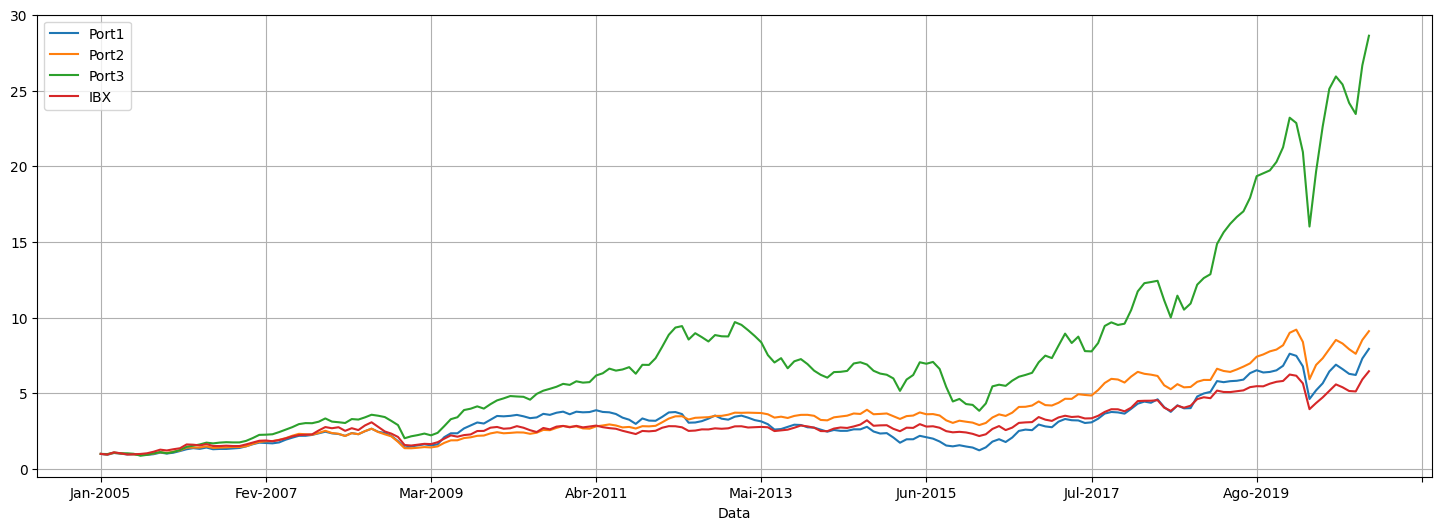

In [ ]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Port1'] = port_acc_vet1
final_df['Port2'] = port_acc_vet2
final_df['Port3'] = port_acc_vet3
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

> Através do gráfico do retorno acumulado no decorrer do período, vemos como o resultado final do portifólio de dois fatores Valor&Qualidade é muito superior aos outros (deixou os outros no chinelo, principalmente o IBX, nossa referência para o mercado).
* Port1: Valor (P/VP) top40
* Port2: Qualidade (ROIC) top40
* Port3: Valor&Qualidade - intersecção dos top40 dos rankings

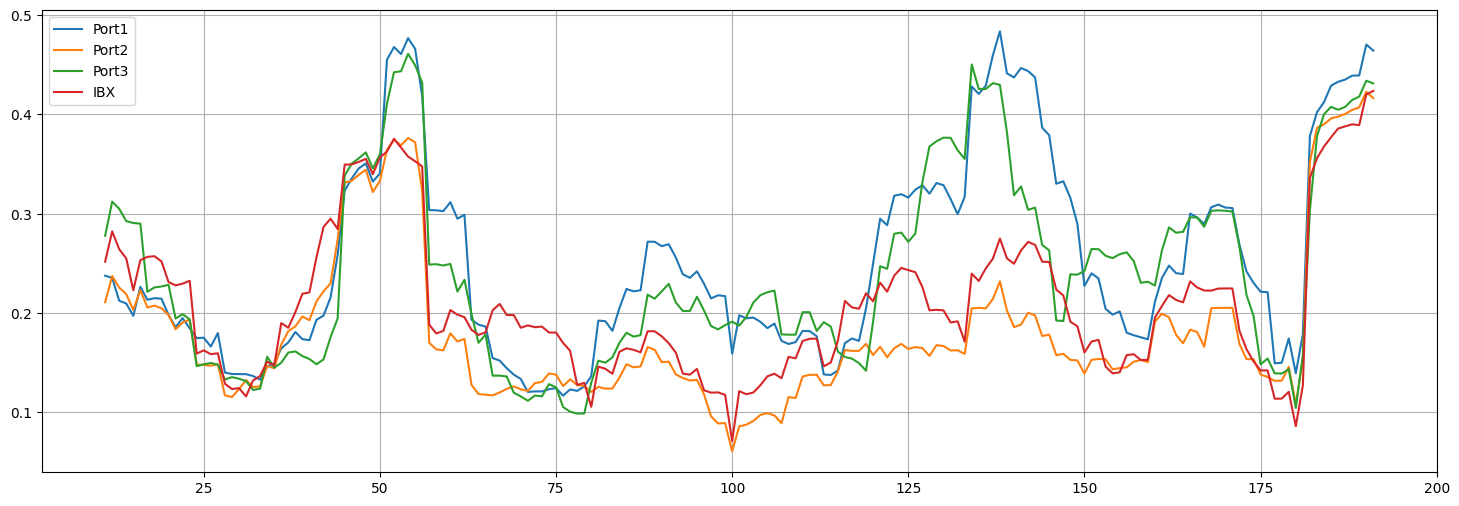

In [ ]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Port1'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port2'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port3'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

> Nosso portifólio apresenta por pequenos períodos de tempo volatilidade similar ao IBX, mas na maior parte do tempo se destaca acima dos outros (melhor apenas do que Port1: Valor top40).

> A volatilidade comparativamente alta não é o ideal, pois aumenta o risco do nosso portifólio, porém o alto retorno (2700% vs. 540% IBX) jusficaria a escolha por algo com 3,5% a mais de volatilidade. Entra em questão o perfil do investidor: depende se há uma busca por mais segurança ou chance de maiores ganhos.


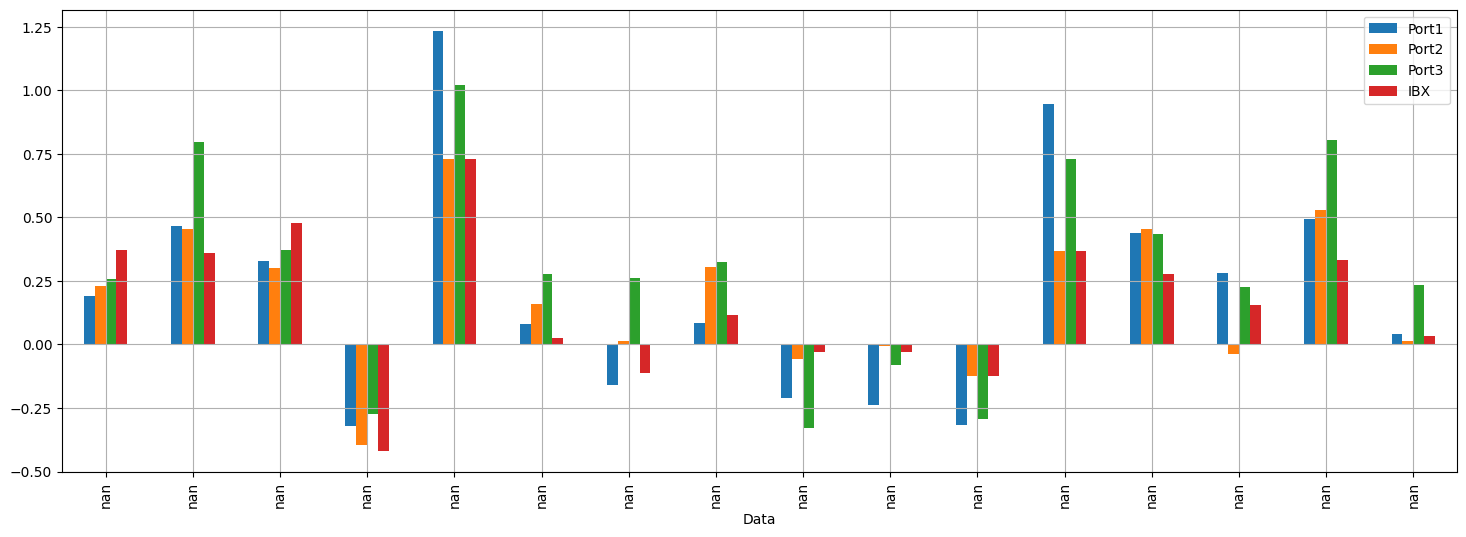

In [ ]:
#Retorno anual de um portfólio e de uma referência (IBX)
final_df12 = pd.DataFrame(columns=['Data', 'Port1', 'Port2', 'Port3', 'IBX'])
for ind in range(0, len(final_df.index)-12, 12):
  final_temp = final_df.iloc[ind+12]/final_df.iloc[ind]-1
  final_df12 = final_df12.append(final_temp, ignore_index=True)

final_df12.set_index(keys = 'Data', inplace = True)
final_df12.plot.bar(figsize=(18,6), grid=True);

### Otimização

> A tentativa de otimizar o portifólio de 2 fatores encontrou um obstáculo misterioso, o código não roda, indica presença de "infs or NaNs" nos dados. Tentei removê-los ou rodar de outras formas, mas até então o erro persiste.

OBS: Erro!

```
----> 5 port_riskfolio = calc_riskfolio_opt(ranked3, 'RP')
# ValueError: array must not contain infs or NaNs
```



In [ ]:
ranked3_0 = ranked3.fillna(0) #continuou com o mesmo erro: 53/204

In [ ]:
nans = list(np.isnan(ranked3_0).any())
infs = list(np.isinf(ranked3_0).any())
for i in nans:
  if i == True:
    print('tem NaN')
for i in infs:
  if i == True:
    print('tem infs')

In [ ]:
#Cálculando portifólio 4, 5, 6
#utilizando intersecção e realizando os 3 processos de otimização
# {RP: risk parity, GMV: global min variance, MDP: max decorrelation port}

port_riskfolio = calc_riskfolio_opt(ranked3_0, 'RP')
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3_0, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3_0, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Maximun Decorrelation Portfolio
 53 / 204 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/riskfolio/src/ParamsEstimation.py:194: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(X.T)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: ignored

## Modelo multifatores 2

Como no primeiro portifólio encontramos uma volatilidade mais alta do que o que gostaríamos, vamos tentar montar um portifólio de menor volatilidade usando esse fator no modelo para selecionar as ações.

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
# Volatilidade
for i in range(10, 101, 10):
  ranked1 = SelPort1(ranked_Vol, 0, i)
  port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
  print("i:",i ,"Ret. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

i: 10 Ret. Acc.: 696.26 % Ret. Anual.: 13.85 % Vol.: 16.41 % Ret/Vol: 0.84 DDown: -36.75 %
i: 20 Ret. Acc.: 709.41 % Ret. Anual.: 13.96 % Vol.: 16.61 % Ret/Vol: 0.84 DDown: -31.69 %
i: 30 Ret. Acc.: 667.5 % Ret. Anual.: 13.58 % Vol.: 17.52 % Ret/Vol: 0.78 DDown: -33.37 %
i: 40 Ret. Acc.: 691.83 % Ret. Anual.: 13.81 % Vol.: 18.11 % Ret/Vol: 0.76 DDown: -36.38 %
i: 50 Ret. Acc.: 701.15 % Ret. Anual.: 13.89 % Vol.: 18.59 % Ret/Vol: 0.75 DDown: -37.5 %
i: 60 Ret. Acc.: 639.94 % Ret. Anual.: 13.32 % Vol.: 19.41 % Ret/Vol: 0.69 DDown: -40.58 %
i: 70 Ret. Acc.: 651.96 % Ret. Anual.: 13.44 % Vol.: 19.85 % Ret/Vol: 0.68 DDown: -42.98 %
i: 80 Ret. Acc.: 546.15 % Ret. Anual.: 12.37 % Vol.: 20.62 % Ret/Vol: 0.6 DDown: -44.57 %
i: 90 Ret. Acc.: 590.76 % Ret. Anual.: 12.84 % Vol.: 22.03 % Ret/Vol: 0.58 DDown: -46.37 %
i: 100 Ret. Acc.: 492.01 % Ret. Anual.: 11.76 % Vol.: 23.11 % Ret/Vol: 0.51 DDown: -48.41 %


Modelo de portifólio de 3 fatores:
* Valor (Preço / Valor Patrimonial)
* Qualidade (ROIC)
* Volatilidade (12 meses)

Para construção de tal portifólio, adaptou-se a função *SelPort2Par* para comportar 3 fatores e 3 parâmetros, que correspondem ao topo do ranking a ser considerado na intersecção dos ativos melhores colocados em cada fator: nova função *SelPort3Par*.

In [ ]:
#Seleção das ações que compõe um portfólio com 3 fatores.
#Parâmetros: (fator1, limite1, fator2, limite2, fator3, limite3)
#Retorno: portfólio

def SelPort3Par(ranked_1, param_1, ranked_2, param_2, ranked_3, param_3):
  port_ranked_final = ranked_1.copy()
  port_ranked_final.loc[:, :] = 0

  for lin in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranked_1.iat[lin-1, col]  >= 1) and (ranked_1.iat[lin-1, col]  <= param_1) and
          (ranked_2.iat[lin-1, col]  >= 1) and (ranked_2.iat[lin-1, col]  <= param_2) and
          (ranked_3.iat[lin-1, col]  >= 1) and (ranked_3.iat[lin-1, col]  <= param_3)):
        port_ranked_final.iat[lin-1, col] = 1

  return port_ranked_final

Testando com o top50, escolhido por ser um número que parece razoável de modo a obtermos uma intersecção não nula com uma quantidade boa de ações.

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)
top = 50

# Valor (P/VP)
ranked1 = SelPort1(ranked_PVP, 0, top)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1: Valor (P/VP)\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

# Qualidade (ROIC)
ranked2 = SelPort1(ranked_ROIC, 0, top)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2: Qualidade (ROIC)\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

# Volatilidade (12 meses)
ranked3 = SelPort1(ranked_Vol, 0, top)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("Port 3: Volatilidade (12 meses)\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")

Port 1: Valor (P/VP)
Ret. Acc.: 642.02 % Ret. Anual.: 13.34 % Vol.: 26.76 % Ret/Vol: 0.5 DDown: -62.11 %
Port 2: Qualidade (ROIC)
Ret. Acc.: 722.59 % Ret. Anual.: 14.08 % Vol.: 20.42 % Ret/Vol: 0.69 DDown: -46.77 %
Port 3: Volatilidade (12 meses)
Ret. Acc.: 701.15 % Ret. Anual.: 13.89 % Vol.: 18.59 % Ret/Vol: 0.75 DDown: -37.5 %


> A título de comparação, em termos do retorno acumulado e anualizado, os três portifólios de fator único já superam o índice IBX. A volatilidade e DDown do Port1 se mostra um pouco pior, mas já vimos que tudo pode mudar ao se misturar múltiplos fatores na obtenção de um portifólio final incrementado.

```
# Ref IBX: Ret. Acc.: 546.22 % Ret. Anual.: 12.37 % Vol.: 22.69 % Ret/Vol: 0.55 DDown: -49.74 %

```



In [ ]:
#Intersecção: Valor (P/VP) & Qualidade (ROIC) & Volatilidade (12 meses); top primeiras do ranking de cada fator
ranked4 = SelPort3Par(ranked_PVP, top, ranked_ROIC, top, ranked_Vol, top)
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(ranked4, fechamento)
print("Port 4:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")

Port 4:
Ret. Acc.: 1497.61 % Ret. Anual.: 18.91 % Vol.: 20.11 % Ret/Vol: 0.94 DDown: -31.83 %


> Obtivemos um retorno acumulado para o portifólio de 3 fatores muito superior ao dos portifólios de fator único e muito acima do índice de mercado, tido como referência o IBX. Conseguimos uma volatilidade abaixo da do IBX - o que desejávamos e que faltou no portifólio multifatores 1 - e um Ddown reduzido, o que são ótimos indícios.  

Testando o resultado da performance do portifólio para diferentes valores de top do ranking para os fatores... Explorando se há margem para melhora nesse sentido:

In [ ]:
for top in range(30, 101, 10):
  ranked4 = SelPort3Par(ranked_PVP, top, ranked_ROIC, top, ranked_Vol, top)
  port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(ranked4, fechamento)
  print("Port 4: top",top,"\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")

Port 4: top 30 
Ret. Acc.: 0 % Ret. Anual.: 0 % Vol.: 0.0 % Ret/Vol: 0.0 DDown: 0 %
Port 4: top 40 
Ret. Acc.: 0 % Ret. Anual.: 0 % Vol.: 0.0 % Ret/Vol: 0.0 DDown: 0 %
Port 4: top 50 
Ret. Acc.: 1497.61 % Ret. Anual.: 18.91 % Vol.: 20.11 % Ret/Vol: 0.94 DDown: -31.83 %
Port 4: top 60 
Ret. Acc.: 587.0 % Ret. Anual.: 12.8 % Vol.: 20.06 % Ret/Vol: 0.64 DDown: -41.35 %
Port 4: top 70 
Ret. Acc.: 582.68 % Ret. Anual.: 12.76 % Vol.: 19.99 % Ret/Vol: 0.64 DDown: -44.11 %
Port 4: top 80 
Ret. Acc.: 417.53 % Ret. Anual.: 10.82 % Vol.: 20.59 % Ret/Vol: 0.53 DDown: -44.32 %
Port 4: top 90 
Ret. Acc.: 507.6 % Ret. Anual.: 11.94 % Vol.: 21.92 % Ret/Vol: 0.54 DDown: -47.2 %
Port 4: top 100 
Ret. Acc.: 442.82 % Ret. Anual.: 11.15 % Vol.: 22.98 % Ret/Vol: 0.49 DDown: -48.88 %


> Observa-se que para um número menor de ações a serem consideradas na intersecção dos rankings, temos como retorno um portifólio vazio. Ou seja, não adianta ser super exigente, querendo ações perfeitas ou muito boas em muitos aspectos, caso contrário não há ação que sobre depois de tanto filtro. Dentre os valores para os quais obtivemos portifólios, é interessante notar que não há necessariamente uma relação linear entre top e Ret., Vol. e DDown, mas a impressão é que para mais ativos pior o resultado.

Vamos manter top50, pois mostrou-se disparado com o maior retorno acumulado.

In [ ]:
top = 50
#Intersecção: Valor (P/VP) & Qualidade (ROIC) & Volatilidade (12 meses); top primeiras do ranking de cada fator
ranked4 = SelPort3Par(ranked_PVP, top, ranked_ROIC, top, ranked_Vol, top)
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(ranked4, fechamento)
print("Port 4:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")

Port 4:
Ret. Acc.: 1497.61 % Ret. Anual.: 18.91 % Vol.: 20.11 % Ret/Vol: 0.94 DDown: -31.83 %


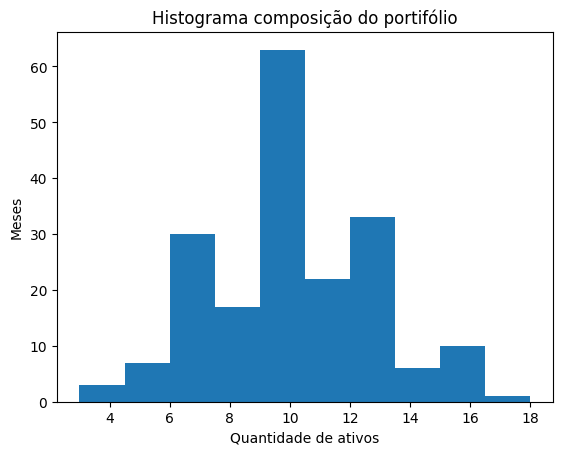

In [ ]:
# Quantidade de ações na composição do portifólio
comp_port4 = []
comp_data_len4 = []
for lin in range(data_inicial, data_final, step_port):
  comp_data = []
  for col in range(0, colunas):
    if (ranked4.iat[lin-1, col] != 0):
      comp_data.append(col)
  comp_port4.append(comp_data)
  comp_data_len4.append(len(comp_data))

plt.hist(comp_data_len4)
plt.title("Histograma composição do portifólio")
plt.xlabel("Quantidade de ativos")
plt.ylabel("Meses")
plt.show()

> Quanto a quantidade de ativos compondo nosso portifólio de 3 fatores, temos que após a intersecção de Valor, Qualidade e Volatilidade entre seus respectivos top50, na maior parte do tempo o portofólio apresenta 10 ativos. Essa seria uma quantidade até que razoável, visto que estamos considerando tantas variáveis.

> *Ps*: é ainda mais curioso se compararmos com a distribuição do número de ativos obtida para o portifólio de 2 fatores: Valor & Qualidade (top40), para o mesmo período. Aqui temos uma distribuição mais simétrica e com portifólios mais diversos em questão de ações distintas.

Analisando mais os resultados do portifólio...

In [ ]:
# CAPM: Capital Asset Pricing Model
# Cálculo de Alpha e Beta aproximados. Parâmetros: (indice_de_referencia, portfolio, coluna_do indice de referencia [0 - Ibovespa, 1 - IBX])
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port4 Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

Port4 Alpha: 8.87 %, Beta: 0.74


> Oscilação desse portifólio corresponde a 74% da oscilação do índice de mercado (beta) e prêmio de 8.87% anualizado. É um portifólio que se compara muito favoravelmente em relação ao mercado.

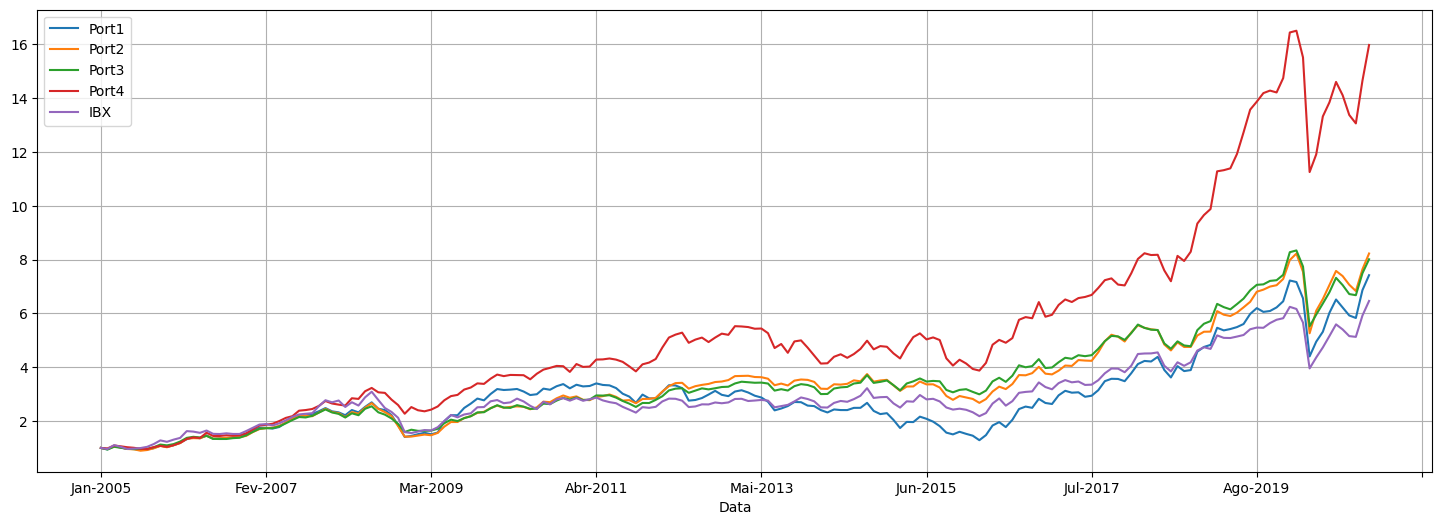

In [ ]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Port1'] = port_acc_vet1
final_df['Port2'] = port_acc_vet2
final_df['Port3'] = port_acc_vet3
final_df['Port4'] = port_acc_vet4
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

> O resultado final do portifólio de 3 fatores (Port4) é muito superior aos outros.

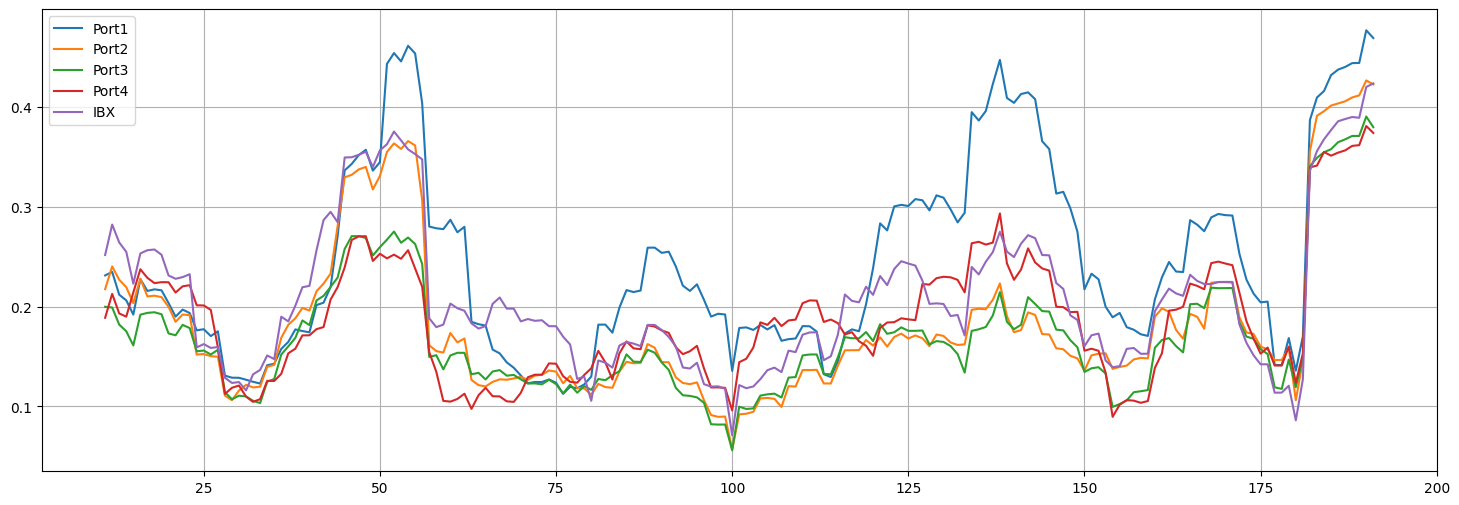

In [ ]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Port1'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port2'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port3'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port4'] = pd.Series(port_chg_vet4).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

> Nosso portifólio apresenta volatilidade a maior parte do tempo baixa, o mais importante, abaixo do índice de referência do mercado IBX.

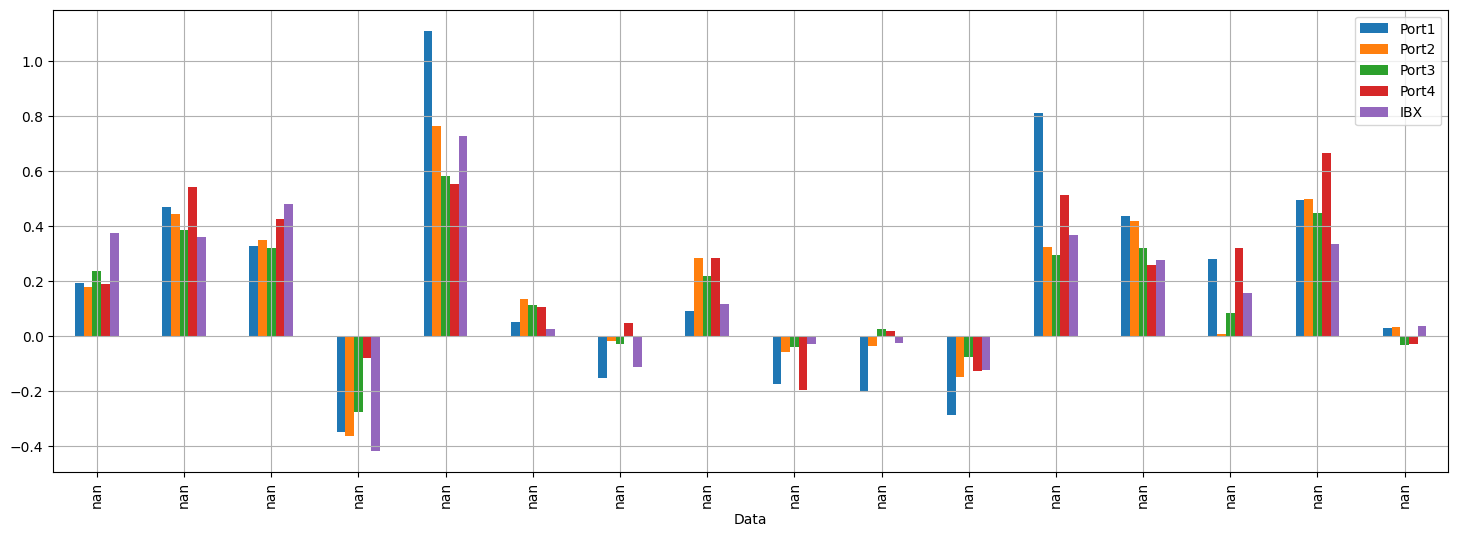

In [ ]:
#Retorno anual de um portfólio e de uma referência (IBX)
final_df12 = pd.DataFrame(columns=['Data', 'Port1', 'Port2', 'Port3', 'Port4', 'IBX'])
for ind in range(0, len(final_df.index)-12, 12):
  final_temp = final_df.iloc[ind+12]/final_df.iloc[ind]-1
  final_df12 = final_df12.append(final_temp, ignore_index=True)

final_df12.set_index(keys = 'Data', inplace = True)
final_df12.plot.bar(figsize=(18,6), grid=True);

> Olhando para o retorno ano a ano, vemos que nosso portifólio é capaz de apresentar um resultado positivo, mesmo enquanto os outros negativam, e cresce bastante de modo geral.

In [ ]:
# Otimização
#Cálculando portifólio 5, 6, 7
#utilizando intersecção e realizando os 3 processos de otimização

port_riskfolio = calc_riskfolio_opt(ranked4, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked4, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked4, 'RP')
port_acc_vet7, port_chg_vet7, port_ddown_vet7, ret_aa7, vol_aa7 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet7[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa7*100,2), "% Vol.:", round(vol_aa7*100,2), "% Ret/Vol:", round(ret_aa7/vol_aa7, 2), "DDown:", round(np.min(port_ddown_vet7)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet7, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Global Minimun Variance Portfolio
 204 / 204 
Port GMV:
Ret. Acc.: 1018.2 % Ret. Anual.: 16.29 % Vol.: 20.06 % Ret/Vol: 0.81 DDown: -40.12 %
Port Alpha: 7.56 %, Beta: 0.67

Calc. Maximun Decorrelation Portfolio
 204 / 204 
Port MDP:
Ret. Acc.: 1286.99 % Ret. Anual.: 17.86 % Vol.: 19.67 % Ret/Vol: 0.91 DDown: -33.4 %
Port Alpha: 8.82 %, Beta: 0.67

Calc. Risk Parity Portfolio
 204 / 204 
Port RP:
Ret. Acc.: 1411.47 % Ret. Anual.: 18.5 % Vol.: 19.6 % Ret/Vol: 0.94 DDown: -31.4 %
Port Alpha: 8.76 %, Beta: 0.71


> Na tentativa de otimizar nosso portifólio de 3 fatores (VQV), de maneira surpreendente (ou não) nenhum dos três processos de otimização empregados resultou em um maior retorno acumulado. No entanto, os três foram capazes de reduzir a volatilidade e o Port7 fruto do cálculo de Risk Parity chega muito próximo, com mesma razão Ret/Vol para 0,5% a menos de volatilidade e -0,4 de DDown.

Ret. Acc.: 1497.61 % Ret. Anual.: 18.91 % Vol.: 20.11 % Ret/Vol: 0.94 DDown: -31.83 %

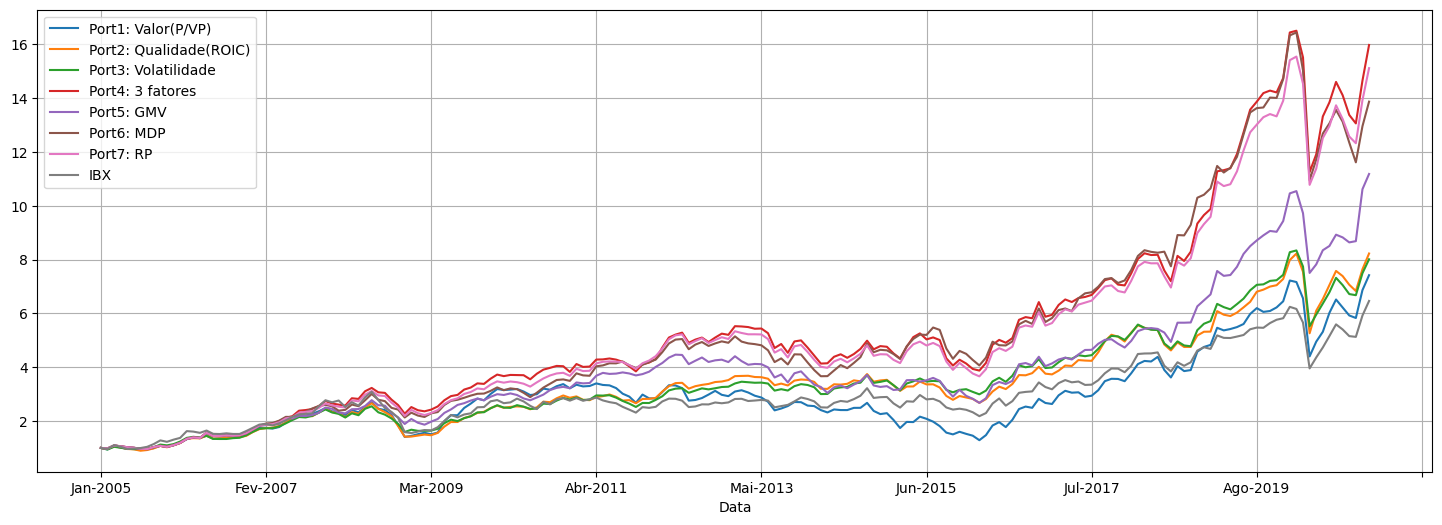

In [ ]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Port1: Valor(P/VP)'] = port_acc_vet1
final_df['Port2: Qualidade(ROIC)'] = port_acc_vet2
final_df['Port3: Volatilidade'] = port_acc_vet3
final_df['Port4: 3 fatores'] = port_acc_vet4
final_df['Port5: GMV'] = port_acc_vet5
final_df['Port6: MDP'] = port_acc_vet6
final_df['Port7: RP'] = port_acc_vet7
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

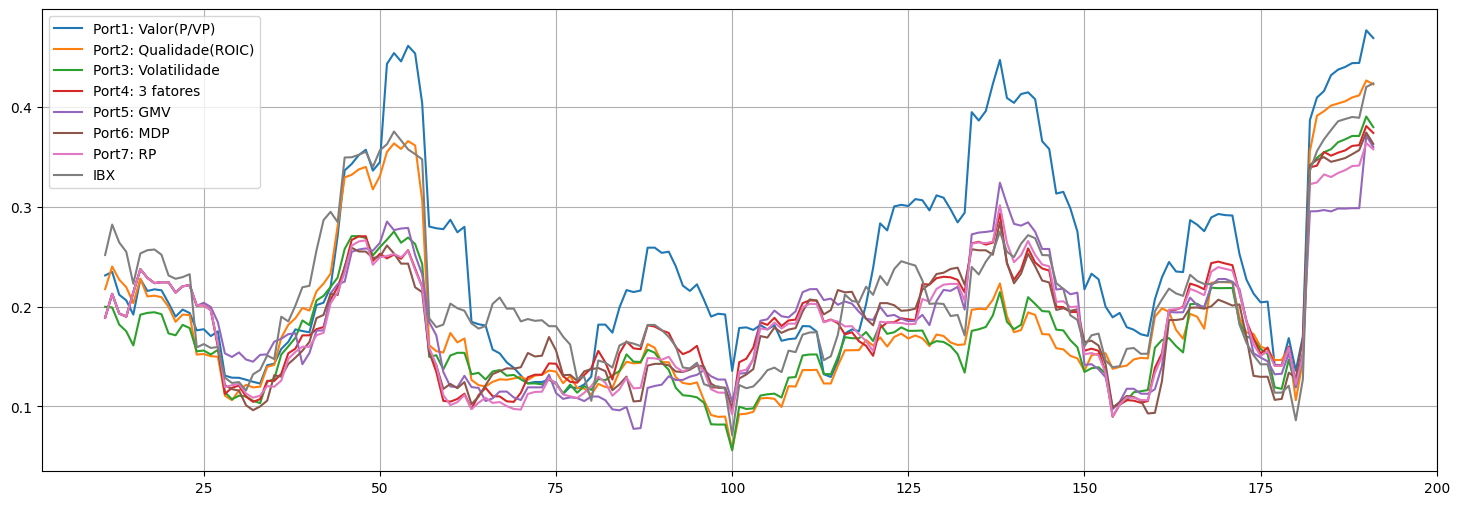

In [ ]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Port1: Valor(P/VP)'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port2: Qualidade(ROIC)'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port3: Volatilidade'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port4: 3 fatores'] = pd.Series(port_chg_vet4).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port5: GMV'] = pd.Series(port_chg_vet5).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port6: MDP'] = pd.Series(port_chg_vet6).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port7: RP'] = pd.Series(port_chg_vet7).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

## Modelo multifatores 3

Criando um último portfólio, apenas para ver se conseguimos bons resultados por meio da otimização do portfólio.

Modelo de portifólio de 2 fatores:
* Momentum
* Qualidade (ROIC das empresas)

In [ ]:
# Avaliação de um portfólio. Parâmetros: (fator, ranking_inicio, ranking_fim)

# Momentum
ranked1 = SelPort1(ranked_Mom, 0, 40)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

# Qualidade (ROIC)
ranked2 = SelPort1(ranked_ROIC, 0, 40)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")

Port 1:
Ret. Acc.: 1114.96 % Ret. Anual.: 16.89 % Vol.: 21.36 % Ret/Vol: 0.79 DDown: -45.54 %
Port 2:
Ret. Acc.: 810.91 % Ret. Anual.: 14.81 % Vol.: 20.4 % Ret/Vol: 0.73 DDown: -48.58 %


In [ ]:
# Portfólio de 2 fatores: Momentum & Qualidade (ROIC)
ranked3 = SelPort2Par(ranked_Mom, 40, ranked_ROIC, 40)
port_acc_vet3, port_chg_vet3, port_ddown_vet3, ret_aa3, vol_aa3 = EvalPort(ranked3, fechamento)
print("\nPort Fator Vol & Qual:\nRet. Acc.:",round(port_acc_vet3[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa3*100,2), "% Vol.:", round(vol_aa3*100,2), "% Ret/Vol:", round(ret_aa3/vol_aa3, 2), "DDown:", round(np.min(port_ddown_vet3)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet3, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Port Fator Vol & Qual:
Ret. Acc.: 1344.59 % Ret. Anual.: 18.16 % Vol.: 21.1 % Ret/Vol: 0.86 DDown: -48.55 %
Port Alpha: 7.73 %, Beta: 0.79


> Obtemos um portfólio de 2 fatores de excelente retorno, superando tanto os portfólios de um único fator, quanto o índice do mercado IBX, além de apresentar menor volatilidade e Drawdown. Temos um portfólio que oscila o correspondente a 79% da oscilação do índice de mercado (beta) e prêmio ajustado ao risco de 7,73% anualizado, muito favorável.

```
# Ref IBX: Ret. Acc.: 546.22 % Ret. Anual.: 12.37 % Vol.: 22.69 % Ret/Vol: 0.55 DDown: -49.74 %

```

In [ ]:
#Cálculando portifólio 4, 5, 6
#utilizando intersecção e realizando os 3 processos de otimização

port_riskfolio = calc_riskfolio_opt(ranked3, 'RP')
port_acc_vet4, port_chg_vet4, port_ddown_vet4, ret_aa4, vol_aa4 = EvalPort(port_riskfolio, fechamento)
print("\nPort RP:\nRet. Acc.:",round(port_acc_vet4[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa4*100,2), "% Vol.:", round(vol_aa4*100,2), "% Ret/Vol:", round(ret_aa4/vol_aa4, 2), "DDown:", round(np.min(port_ddown_vet4)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet4, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'GMV')
port_acc_vet5, port_chg_vet5, port_ddown_vet5, ret_aa5, vol_aa5 = EvalPort(port_riskfolio, fechamento)
print("\nPort GMV:\nRet. Acc.:",round(port_acc_vet5[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa5*100,2), "% Vol.:", round(vol_aa5*100,2), "% Ret/Vol:", round(ret_aa5/vol_aa5, 2), "DDown:", round(np.min(port_ddown_vet5)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet5, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

port_riskfolio = calc_riskfolio_opt(ranked3, 'MDP')
port_acc_vet6, port_chg_vet6, port_ddown_vet6, ret_aa6, vol_aa6 = EvalPort(port_riskfolio, fechamento)
print("\nPort MDP:\nRet. Acc.:",round(port_acc_vet6[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa6*100,2), "% Vol.:", round(vol_aa6*100,2), "% Ret/Vol:", round(ret_aa6/vol_aa6, 2), "DDown:", round(np.min(port_ddown_vet6)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet6, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))


Calc. Risk Parity Portfolio
 204 / 204 
Port RP:
Ret. Acc.: 1095.2 % Ret. Anual.: 16.77 % Vol.: 19.28 % Ret/Vol: 0.87 DDown: -42.41 %
Port Alpha: 7.43 %, Beta: 0.7

Calc. Global Minimun Variance Portfolio
 204 / 204 
Port GMV:
Ret. Acc.: 504.87 % Ret. Anual.: 11.91 % Vol.: 18.93 % Ret/Vol: 0.63 DDown: -35.53 %
Port Alpha: 4.76 %, Beta: 0.58

Calc. Maximun Decorrelation Portfolio
 204 / 204 
Port MDP:
Ret. Acc.: 1993.7 % Ret. Anual.: 20.94 % Vol.: 21.15 % Ret/Vol: 0.99 DDown: -44.12 %
Port Alpha: 12.03 %, Beta: 0.65


> A otimização do portfólio nos devolve bons portfólios, com o obtido através do cálculo de máxima decorrelação superando em muito o resultado anterior: MDP Ret. Acc.: 1993,7%, com praticamente a mesma volatilidade do portfólio antes do processo de otimização, excelente.

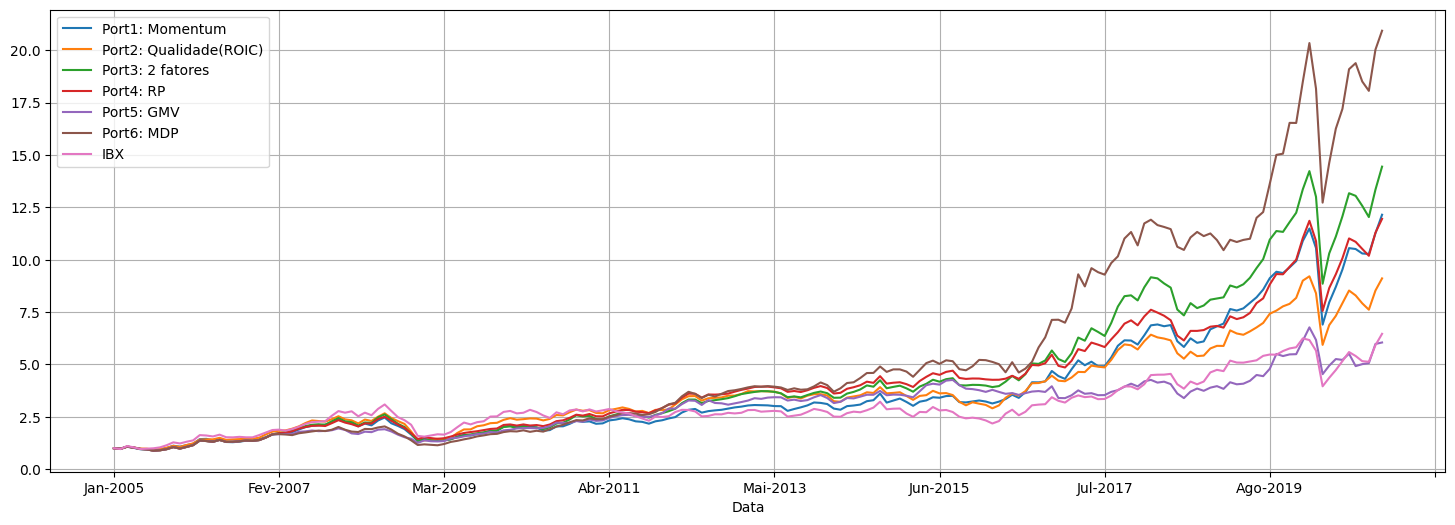

In [ ]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Port1: Momentum'] = port_acc_vet1
final_df['Port2: Qualidade(ROIC)'] = port_acc_vet2
final_df['Port3: 2 fatores'] = port_acc_vet3
final_df['Port4: RP'] = port_acc_vet4
final_df['Port5: GMV'] = port_acc_vet5
final_df['Port6: MDP'] = port_acc_vet6
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

> Vemos como o retorno acumulado do portfólio de 2 fatores: Momentum & Qualidade se sai muito melhor do que o do mercado e como ainda assim o portfólio otimizado MDP é capaz de ir ainda melhor no mesmo período.

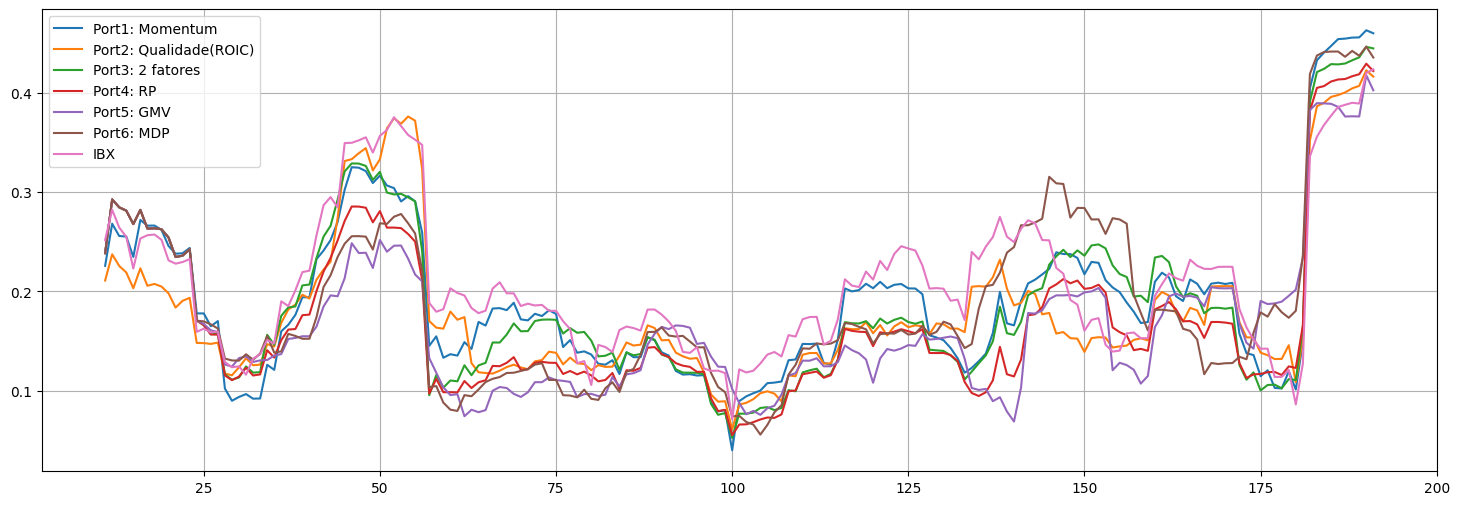

In [ ]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Port1: Momentum'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port2: Qualidade(ROIC)'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port3: 2 fatores'] = pd.Series(port_chg_vet3).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port4: RP'] = pd.Series(port_chg_vet4).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port5: GMV'] = pd.Series(port_chg_vet5).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port6: MDP'] = pd.Series(port_chg_vet6).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

> Em termos de volatilidade, os portfólios parecem andar bem juntos, porém nota-se que na maior parte do tempo o portfólio MDP se encontra abaixo da volatilidade do IBX, o que é ótimo.

E quais seriam as ações que comporiam nosso portifólio caso escolhessemos esse modelo multifatores?

In [ ]:
# Quais seriam essas ações? Última composição para o período (Dez-2020)
# Para o portfólio otimizado: MDP

comp_port3 = []
comp_data_len = []
for lin in range(data_inicial, data_final, step_port):
  comp_data = []
  for col in range(0, colunas):
    if (port_riskfolio.iat[lin-1, col] != 0):
      comp_data.append(col)
  comp_port3.append(comp_data)
  comp_data_len.append(len(comp_data))

acoes = list(port_riskfolio.columns.values) #291 ações distintas

ac = []
for i in comp_port3[191]: #192 linhas (período: 16anos*12meses = 192)
  acc = []
  for j in range(3, len(acoes[i])):
    acc.append(acoes[i][j])
  acc = ''.join(acc)
  ac.append(acc)
print(ac)
print(len(ac))

['ALPA4', 'B3SA3', 'CRFB3', 'CPLE6', 'HAPV3', 'GNDI3', 'JHSF3', 'RENT3', 'LAME3', 'MRFG3', 'PRIO3', 'RAPT4', 'TAEE11', 'TOTS3', 'TRPL4', 'WEGE3']
16


# Resumo dos resultados

Foram construídos três modelos de portfólios multifatores, que indicam diretrizes de como compor a carteira em resposta à evolução dos fatores escolhidos no modelo que descrevem características quantitativas das empresas. Nesse tipo de modelagem, pesa mais a estratégia da escolha dos fatores do que dos ativos, sendo importante notar que os resultados obtidos para cada um dos modelos aqui ilustrados correspondem a uma contínua reavaliação e recomposição do portfólio, conforme o cenário econômico se modifica e o indicador do fator escolhido se altera.

Melhores portfólios obtidos para cada um dos modelos considerando diferentes fatores, quantidade de ações para realização da intersecção e cruzamento entre os fatores e otimizações:

* **Modelo multifatores 1**: 2 fatores - Valor(P/VP) & Qualidade(ROIC); intersecção entre os top 40 dos rankings dos fatores; ponderação uniforme

  * Ret. Acc.: 2762.97 % Ret. Anual.: 23.32 % Vol.: 26.27 % Ret/Vol: 0.89 DDown: -60.37 %
  * Port3 Alpha: 11.61 %, Beta: 0.91

* **Modelo multifatores 2**: 3 fatores - Valor(P/VP), Qualidade(ROIC) e Volatilidade; intersecção entre os top 50 dos rankings dos fatores
  
  Ponderação uniforme:
  * Ret. Acc.: 1497.61 % Ret. Anual.: 18.91 % Vol.: 20.11 % Ret/Vol: 0.94 DDown: -31.83 %
  * Port4 Alpha: 8.87 %, Beta: 0.74

  Otimização RP:
  * Ret. Acc.: 1411.47 % Ret. Anual.: 18.5 % Vol.: 19.6 % Ret/Vol: 0.94 DDown: -31.4 %
  * Port Alpha: 8.76 %, Beta: 0.71

* **Modelo multifatores 3**: 2 fatores - Momentum & Qualidade(ROIC); intersecção entre os top 40 dos rankings dos fatores; otimização por MDP

 * Port MDP: Ret. Acc.: 1993.7 % Ret. Anual.: 20.94 % Vol.: 21.15 % Ret/Vol: 0.99 DDown: -44.12 %
 * Port Alpha: 12.03 %, Beta: 0.65


Dentre os três modelos, pensando na maior rentabilidade possível, a combinação de Valor & Qualidade rendeu o maior retorno de todos, absurdos 2762,97%, sendo o modelo multifatores 1 o campeão. No entando, pensando em menor volatilidade, ou pelo menos menor do que a do IBX (Vol.: 22.69 %), o modelo multifatores 3 entrega um retorno de 1993,7%, além de apresentar o maior prêmio alfa, com uma volatilidade de 21,15%. O investidor poderia então escolher se prefere ariscar mais para tentar ganhar mais, ou ficar em uma maior zona de segurança, menos volátil do que o mercado. Se fosse para de fato criar um portfólio para começar a investir, bastaria a pessoa rodar o modelo escolhido com os dados mais atualizados e por na sua carteira inicial as ações mais recentes presentes no portifólio gerado pelo modelo.

# Conclusão

No trabalho 2 foi possível explorar o conceito e as práticas do *factor investing*, menos intuitivo e de certa forma mais objetivo. Ao invés de olhar para ações específicas e fazer considerações individuais para sua escolha, baseadas em análise fundamentalista e, claro, sujeitas aos viéses intrínsecos do ser humano, é possível montar um portfólio tendo como "bússola" fatores, características quantificávies, que se relacionam com o desempenho do ativo. Empregamos para seleção das ações uma função de ranking simples para cada um dos fatores, seguida da interseção das melhores ações (top) entre os fatores para compor nosso portifólio, apenas uma dentre uma infinidade de funções possíveis, e, mesmo sem inventar muito, obtivemos portfólios com resultados excelentes. Além disso, também foi possível explorar otimização de portfólio de três maneiras distintas: Global Minimun Variance, Maximun Decorrelation e Risk Parity. De modo geral, vimos como uma carteira pode ser montada ao se combinar fatores - dentre eles valor, qualidade, volatilidade, momentum, tamanho da empresa - e que é possível superar o mercado através dessas combinações (não óbvias) de ativos, apenas ilustrando a miríade de opções possíveis por meio da abordagem de investimento em fatores.